In [1]:
import torch
import random
from tqdm import tqdm
from torch.utils.data import Dataset
import math
import pandas as pd #only used for viewing the datset
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" ## since my kernel always breaks down suddenly , I have to add this line

In [2]:
class mandelbrotDataSet: 
    """
    
    
    this is the datset that the NN will be trained on!
    
    The following init function computes the Mandelbrot set in a half-width square area centered at (x_enter,y_center). 
    This square area has an x-coordinate range of x_center±semi_width and a y-coordinate range of y_center±semi_width.
    
    Output is a two-dimensional matrix with the value of the maximum number of iterations per c without exceeding 
    a threshold, which is used here for map different colors. So, the output can use to draw image directly. 
    
    """
    def __init__(self,  x_center=0.2,y_center=0.5,semi_width=0.2,size = 600, max_depth = 50):
        ## N = size * size elements, default is a N= 600 * 600 =360000 elements set.
        self.size = size      
        self.max_depth = max_depth
        self.outputs = []
        self.x_from,self.x_to,self.y_from,self.y_to = x_center-semi_width,x_center+semi_width,\
                          y_center-semi_width,y_center+semi_width
        
        ## np.ogrid() is similar to np.linspace() but return two-dimensional array
        self.y,self.x = np.ogrid[self.y_from:self.y_to:self.size*1j,self.x_from:self.x_to:self.size*1j]
        
        ## the value of matrix c is complex, and size of c is size * size, default is 600*600
        self.c = self.x + self.y*1j
        print("c.shape:",self.c.shape,"x.shape:",self.x.shape,"y.shape:",self.y.shape)
        
        ## a two dimensional matrix with length and width eaqual to self.size
        self.outputs=np.frompyfunc(self.f,1,1)(self.c).astype(np.float)
        
                    
    
    def f(self, a):
        """ Itterates up to max depth to check if a complex number belongs to the madelbrot set or not."""
        z = 0
        ## The maximum escape time is max_depth-1 
        for n in range(1, self.max_depth):
            z = z ** 2 + a
            if abs(z) > 2:
                return n ## the iterate times is used to map colors
        return n 

    def get_X_and_Y(self):
        
        xc=np.squeeze(self.c.real.reshape(1,-1))## get real part and reshape to a vector
        yc=np.squeeze(self.c.imag.reshape(1,-1))## get imaginary part and reshape to a vector
        color=np.squeeze(self.outputs.reshape(1,-1))
        label=(color==self.max_depth-1)
        return np.array(list(zip(xc,yc))),label,color
            
    def view(self):
        dataframe = pd.DataFrame(data = [], columns = ["x","y", "Belongs?","color"])
        xc=np.squeeze(self.c.real.reshape(1,-1))## get real part and reshape to a vector
        yc=np.squeeze(self.c.imag.reshape(1,-1))## get imaginary part and reshape to a vector
        dataframe.x=xc
        dataframe.y=yc
        color=np.squeeze(self.outputs.reshape(1,-1))# get outputs and reshape to a vector
        dataframe.color=color
        dataframe["Belongs?"]= (color==self.max_depth-1)

        return dataframe       
            
                

In [3]:
dataset = mandelbrotDataSet(size=600) #by default we will generate 600*600=360000 instances 

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)


C:\Users\Jerry Yuan\AppData\Local\Temp\ipykernel_18224\2220523869.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.outputs=np.frompyfunc(self.f,1,1)(self.c).astype(np.float)


In [5]:
dataset.view()

,x,y,Belongs?,color
0,0.000000,0.3,True,49.0
1,0.004040,0.3,True,49.0
2,0.008081,0.3,True,49.0
3,0.012121,0.3,True,49.0
4,0.016162,0.3,True,49.0
...,...,...,...,...
9995,0.383838,0.7,False,6.0
9996,0.387879,0.7,False,6.0
9997,0.391919,0.7,False,6.0
9998,0.395960,0.7,False,5.0


In [10]:
X, Y,Color = dataset.get_X_and_Y() 
X,Y,Color

(array([[0.00000000e+00, 3.00000000e-01],
        [6.67779633e-04, 3.00000000e-01],
        [1.33555927e-03, 3.00000000e-01],
        ...,
        [3.98664441e-01, 7.00000000e-01],
        [3.99332220e-01, 7.00000000e-01],
        [4.00000000e-01, 7.00000000e-01]]),
 array([ True,  True,  True, ..., False, False, False]),
 array([49., 49., 49., ...,  5.,  5.,  5.]))

In [5]:
"""
you can use the code below to generate any mandelbrot set image, just provide a 'ds' argument, the 'ds'
argument is a square matrix, same to the outputs of the mandelbrotDataSet. You can also use the 'mandelbrotDataSetInstance'.outputs
to generate the image.
""" 

from matplotlib import cm
from matplotlib import pyplot as plt

class Para: ## A Para class with only a name is used to store global parameters
    pass


para = Para()
## You can change the color of the image by changing the idxColorMap
para.idxColorMap = 1
## the total color type is in cmaps list
para.cmaps = [ 'ocean', 'gist_earth', 'terrain', 'gist_stern',
         'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg','gist_rainbow',
         'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']


def drawImage(ds,cmaps):
    para.fig = plt.figure(figsize=(12,6),dpi=100)
    para.ax0 = plt.subplot(121)
    para.ax0.set_axis_off()## Hide the coordinates of the subgraph
    c = cm.get_cmap(cmaps[para.idxColorMap%len(cmaps)])
    ## The cmap function inside imshow() corresponds to a color map object, which is responsible for converting the value of the 
    ## element (i.e., the escape time of the complex c) to the corresponding color.
    para.ax0.imshow(ds,cmap=c)


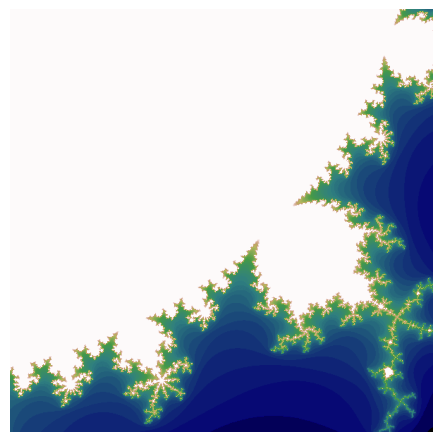

In [28]:
## ds = dataset.outputs
drawImage(dataset.outputs,para.cmaps)

In [7]:
## Changing the coordinates and reducing the width, leaving the size unchanged, that is zoom in the image
dataset2=mandelbrotDataSet(x_center=0.27,y_center=0.59,semi_width=0.02)

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)


C:\Users\Jerry Yuan\AppData\Local\Temp\ipykernel_18224\2220523869.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.outputs=np.frompyfunc(self.f,1,1)(self.c).astype(np.float)


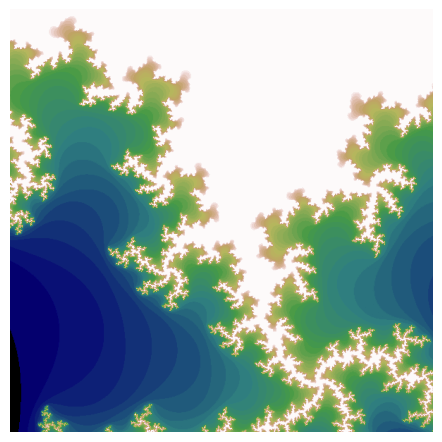

In [8]:
drawImage(dataset2.outputs,para.cmaps)

In [11]:
X_train, X_test = X[:math.ceil(X.shape[0] * 0.8)], X[math.ceil(X.shape[0] * 0.8):]
Y_train, Y_test = Y[:math.ceil(Y.shape[0] * 0.8)], Y[math.ceil(Y.shape[0] * 0.8):]

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape  = [2, 1])) #each image array is 28 x 28 and each image array is input, and flatten it. 
model.add(keras.layers.Dense(300, activation = "relu")) #fukly conencted layer with 300 neurons. using relu activation function. = 300 * (28 * 28) weights and 300 biases
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(2, activation = "softmax")) #output layer has 10 neurons because 10 classes. 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 300)               900       
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 31,202
Trainable params: 31,202
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"]) #learwning rate defaults to 0.01

In [16]:
history = model.fit(X_train, Y_train, epochs = 50, validation_data = (X_test, Y_test))

Epoch 1/50
9000/9000 [==============================] - 13s 1ms/step - loss: 0.2973 - accuracy: 0.8603 - val_loss: 0.8897 - val_accuracy: 0.6535
Epoch 2/50
9000/9000 [==============================] - 12s 1ms/step - loss: 0.2232 - accuracy: 0.8864 - val_loss: 0.7855 - val_accuracy: 0.6837
Epoch 3/50
9000/9000 [==============================] - 12s 1ms/step - loss: 0.2199 - accuracy: 0.8878 - val_loss: 0.6514 - val_accuracy: 0.7193
Epoch 4/50
9000/9000 [==============================] - 12s 1ms/step - loss: 0.2095 - accuracy: 0.8941 - val_loss: 0.4592 - val_accuracy: 0.7712
Epoch 5/50
9000/9000 [==============================] - 13s 1ms/step - loss: 0.1910 - accuracy: 0.9054 - val_loss: 0.2214 - val_accuracy: 0.9037
Epoch 6/50
9000/9000 [==============================] - 14s 2ms/step - loss: 0.1815 - accuracy: 0.9111 - val_loss: 0.1904 - val_accuracy: 0.9184
Epoch 7/50
9000/9000 [==============================] - 14s 2ms/step - loss: 0.1777 - accuracy: 0.9136 - val_loss: 0.1767 - val_ac

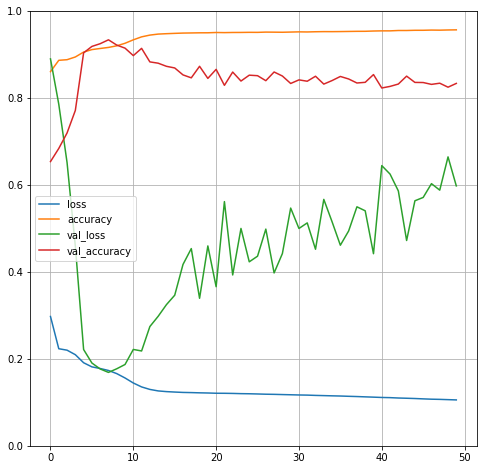

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize = (8, 8))

plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [18]:
model.evaluate(X_test, Y_test) # returns (loss, accuracy)

2250/2250 [==============================] - 2s 951us/step - loss: 0.5976 - accuracy: 0.8333


[0.5976101756095886, 0.8333194255828857]

In [24]:

new_dataset = dataset = mandelbrotDataSet() 
X,Label,Color = dataset.get_X_and_Y()

predictions = model.predict(X)
predictions_as_classes = np.argmax(predictions, axis=1)
predictions_as_classes

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)


C:\Users\Jerry Yuan\AppData\Local\Temp\ipykernel_18224\2220523869.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.outputs=np.frompyfunc(self.f,1,1)(self.c).astype(np.float)


11250/11250 [==============================] - 9s 765us/step


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [27]:
predictions_as_classes.reshape(600,-1)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)